## Social media habits of misinformation spreaders

Name: Zhenmin Hua  
USC-ID: 5905057247  
Email: zhenmin@usc.edu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x:'%.5f' % x)

In [2]:
df = pd.read_csv('data_naseela.csv', nrows=20000, encoding='utf-8', on_bad_lines='skip')

#### Data Exploration

In [3]:
df.sample(3)

,tweetid,userid,screen_name,date,lang,location,description,place_id,place_url,place_type,...,qtd_reply_count,qtd_fav_count,qtd_tweetid,qtd_urls_list,qtd_location,sent_vader,token,media_urls,rt_media_urls,q_media_urls
12139,1496636480449662976.00000,901839547,owlinF,Thu Feb 24 00:01:57 +0000 2022,ja,NaN,"love nature,soccer,vehicle 日本が大好き。日本人であることを誇りに...",NaN,NaN,NaN,...,0.00000,0.00000,NaN,[],NaN,0.00000,日本には不思議と、「武力による威嚇」を平然とやってのけるロシアの「お気持ち」を代弁する人ばか...,[],[],[]
8924,NaN,NaN,NaN,DC,United States,NaN,NaN,NaN,United States,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6455,1496636238786437120.00000,868768568283975680,Sahidkapadia3,Thu Feb 24 00:01:00 +0000 2022,en,"Philadelphia, PA",NaN,NaN,NaN,NaN,...,0.00000,0.00000,NaN,[],NaN,0.12800,the mayor kyiv vitaly klitschko declared emerg...,[],[],[]


In [4]:
df.columns

Index(['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'description', 'place_id', 'place_url', 'place_type', 'place_name',
       'place_full_name', 'place_country_code', 'place_country',
       'place_bounding_box', 'text', 'extended', 'coord', 'reply_userid',
       'reply_screen', 'reply_statusid', 'tweet_type', 'friends_count',
       'listed_count', 'followers_count', 'favourites_count', 'statuses_count',
       'verified', 'hashtag', 'urls_list', 'profile_pic_url',
       'profile_banner_url', 'display_name', 'date_first_tweet',
       'account_creation_date', 'rt_urls_list', 'mentionid', 'mentionsn',
       'rt_screen', 'rt_userid', 'rt_user_description', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'rt_location', 'qtd_screen', 'qtd_userid',
       'qtd_user_description', 'qtd_text', 'qtd_hashtag', 'qtd_qtd_count',
       'qtd_rt_count', 'qtd_reply_count', 'qtd_fav_count', 'qtd_tweeti

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweetid                10000 non-null  float64
 1   userid                 11962 non-null  object 
 2   screen_name            13899 non-null  object 
 3   date                   11310 non-null  object 
 4   lang                   12756 non-null  object 
 5   location               6718 non-null   object 
 6   description            9209 non-null   object 
 7   place_id               3949 non-null   object 
 8   place_url              2806 non-null   object 
 9   place_type             1113 non-null   object 
 10  place_name             10050 non-null  object 
 11  place_full_name        50 non-null     object 
 12  place_country_code     50 non-null     object 
 13  place_country          50 non-null     object 
 14  place_bounding_box     50 non-null     object 
 15  te

#### check missing values  
As we can see in the charts, some of the columns have lots of NULL values.  
So I am thinking to drop some values later.

<AxesSubplot:>

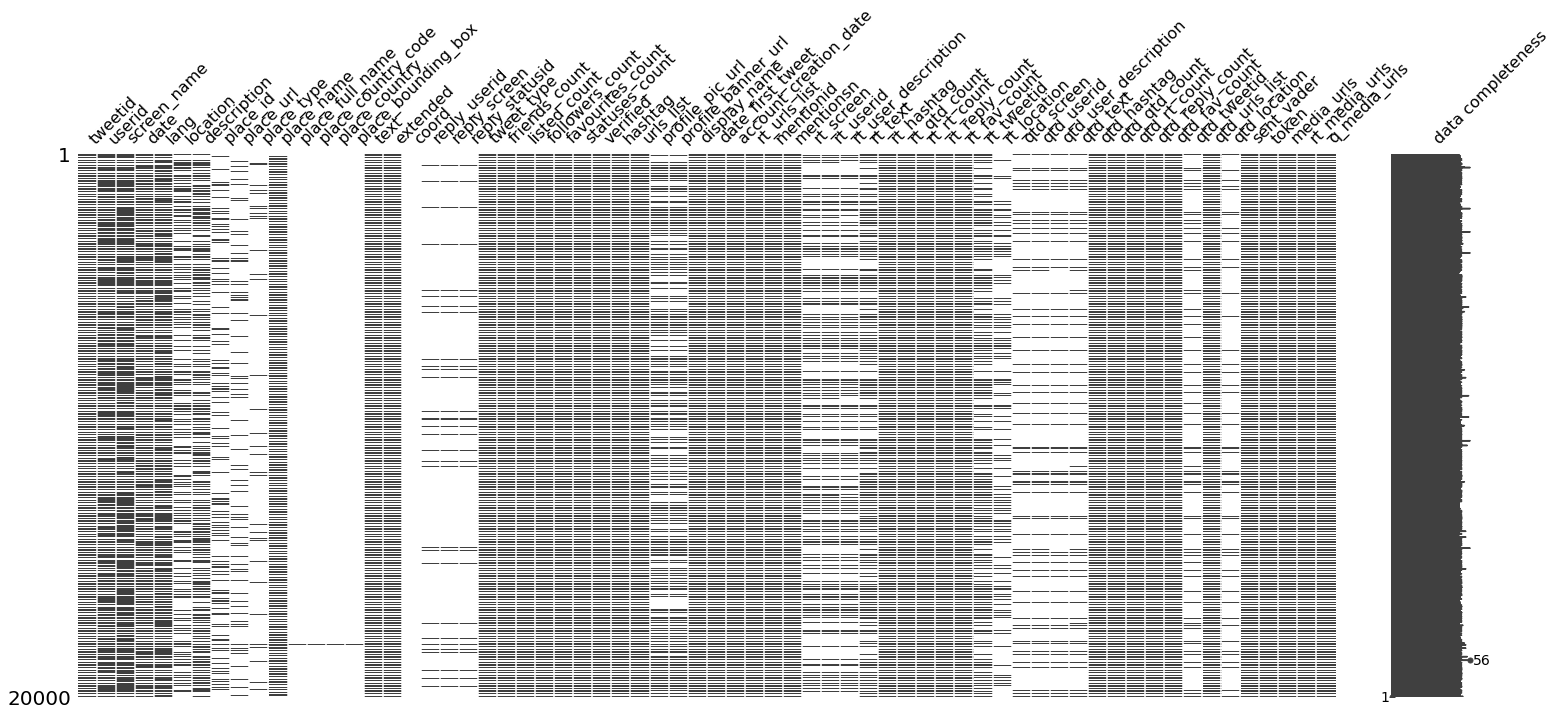

In [6]:
import missingno as msno
msno.matrix(df, labels=True)

<AxesSubplot:>

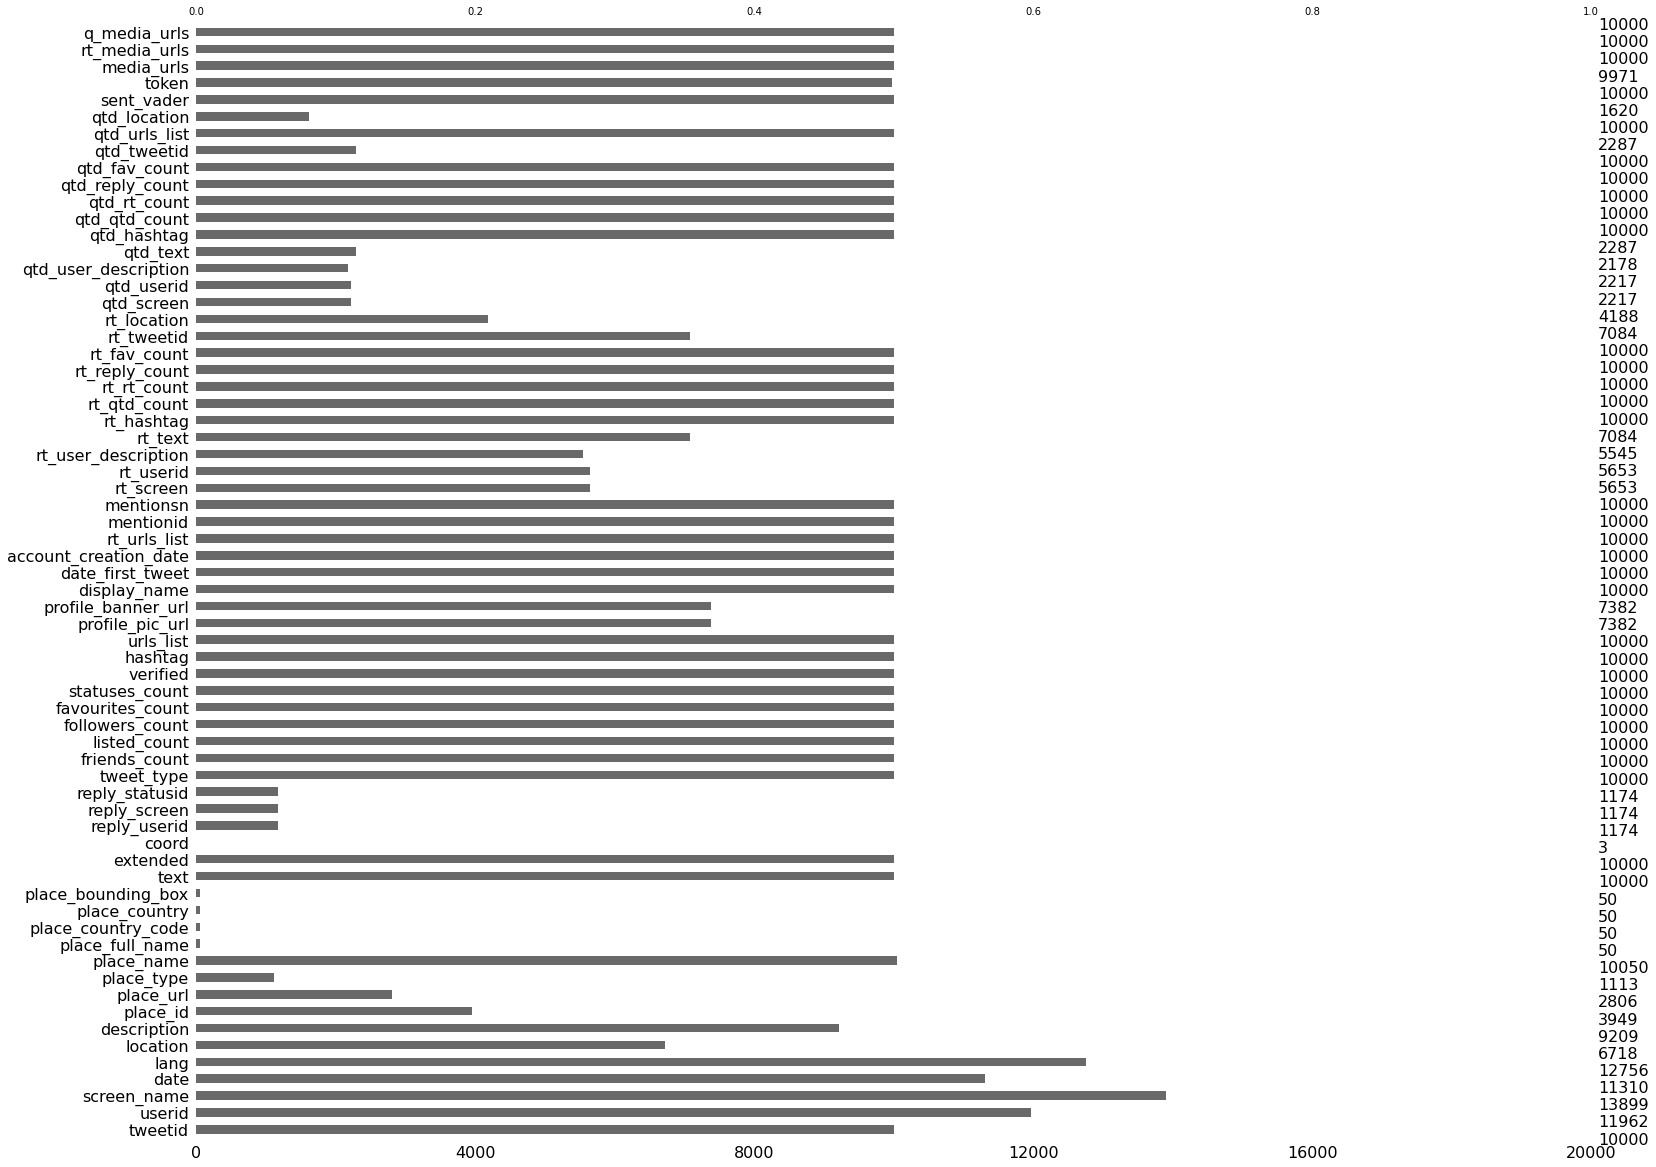

In [7]:
msno.bar(df)

#### drop the records without any id

In [8]:
# drop the records without any id
df.dropna(axis=0, subset=['tweetid', 'userid'], how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
print(f'Number of users in this chunk: {df.shape[0]}')
print(f'Number of attributes collected: {df.shape[1]}')

Number of users in this chunk: 11962
Number of attributes collected: 66


#### process date time

In [10]:
df['date2'] = pd.to_datetime(df['date'], errors='coerce')

In [11]:
df.date2

0                             NaT
1       2022-02-23 23:59:54+00:00
2       2022-02-23 23:59:54+00:00
3       2022-02-23 23:59:54+00:00
4       2022-02-23 23:59:54+00:00
                   ...           
11957   2022-02-24 00:03:17+00:00
11958   2022-02-24 00:03:17+00:00
11959   2022-02-24 00:03:17+00:00
11960   2022-02-24 00:03:17+00:00
11961   2022-02-24 00:03:17+00:00
Name: date2, Length: 11962, dtype: datetime64[ns, UTC]

#### visualize the language usage  (user habit detection)
According to the visualization, most tweet users use English as their language of posting or retweeting.

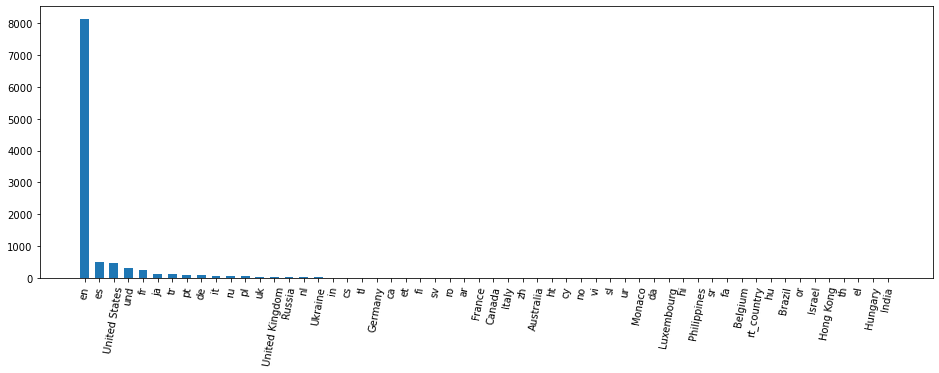

In [12]:
# bar chart
langs = df.lang.value_counts().index
num_list = list(df.lang.value_counts())
plt.figure(figsize=(16,5))
plt.bar(range(len(num_list)), num_list, width=0.6, tick_label=langs)
plt.xticks(rotation=80)
plt.show()

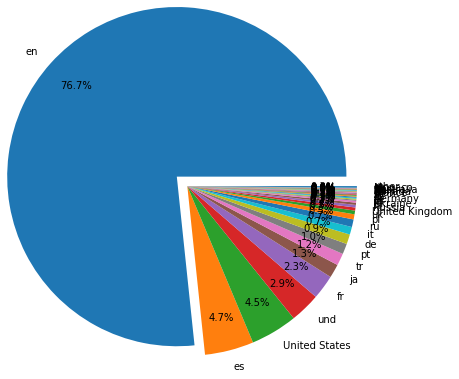

In [13]:
# pie chart
data = list(df.lang.value_counts())
other = sum(filter(lambda x: x == 1, data))
data = data[:-other]
data.append(other)
label = list(df.lang.value_counts().index[:-other])
label.append('other')

plt.figure(figsize=(20, 6.5))
plt.pie(data,
        labels=label,
        #colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"], 
        explode=[0.1] + [0]*(len(label)-1), 
        autopct='%.1f%%', 
        radius=1.2,
        pctdistance=0.8,
       )
plt.show()

#### visualize the tweet_type  (user habit detection)
According to the pie chart, more than half of the tweet users' action is retweet without comment. 'Quote tweet' is another action that tweet users usually do on tweet. In a sense, retweeting and quoting have some similar attribute which is that they both utilize the text information originated from another user. So it seems tweeters in this dataset like to generate their tweets from others. 

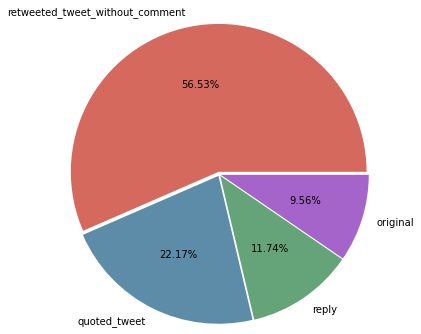

In [14]:
# pie chart
data = list(df.tweet_type.value_counts())
label = df.tweet_type.value_counts().index

plt.pie(data,
        labels=label,
        colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"], 
        explode=(0.03, 0.02, 0.02, 0.02),
        autopct='%.2f%%',
        radius=1.7,
       )
plt.show()

#### check the distribution of friends_count  
The count of friends has a very large gap so it seems.

In [15]:
df['friends_count'].describe()

count    10000.00000
mean      2201.03360
std       5618.61028
min          0.00000
25%        268.75000
50%        815.00000
75%       2509.75000
max     229787.00000
Name: friends_count, dtype: float64

(array([2., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 956. , 1425.7, 1895.4, 2365.1, 2834.8, 3304.5, 3774.2, 4243.9,
        4713.6, 5183.3, 5653. ]),
 <BarContainer object of 10 artists>)

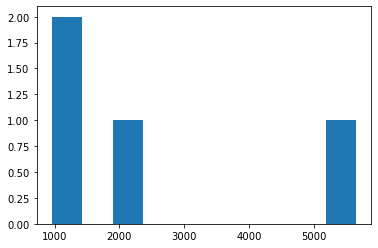

In [16]:
plt.hist(data)

#### check the distribution of followers_count

In [17]:
df['followers_count'].describe()

count      10000.00000
mean       11816.86600
std       211927.69782
min            0.00000
25%          115.00000
50%          493.50000
75%         1899.00000
max     13390542.00000
Name: followers_count, dtype: float64

(array([9981.,   10.,    4.,    1.,    1.,    1.,    1.,    0.,    0.,
           1.]),
 array([       0. ,  1339054.2,  2678108.4,  4017162.6,  5356216.8,
         6695271. ,  8034325.2,  9373379.4, 10712433.6, 12051487.8,
        13390542. ]),
 <BarContainer object of 10 artists>)

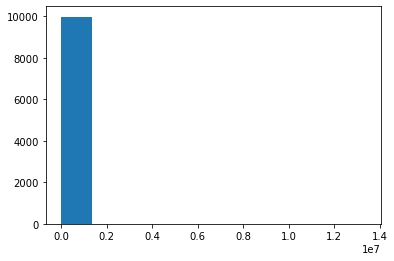

In [18]:
plt.hist(df['followers_count'])

#### Next I want to do the sentiment analysis upon the texts

In [19]:
df['text']

0                                                      NaN
1        RT @antontroian: Zelensky addressing the Russi...
2        @rcoyle71 @repdarrellissa Now we are back to b...
3        RT @nytimes: Breaking News: Ukraine’s presiden...
4        @drparker76 Exactly. He caught them all. NCSWI...
                               ...                        
11957    RT @MundoEConflicto: 🇷🇺🇺🇦 | Dos convoyes separ...
11958    RT @Archer83Able: Zaporozhye airport in Ukrain...
11959    RT @CalltoActivism: If we exposed every single...
11960    @nytimes The U.S, Ukraine and our allies have ...
11961    RT @KatiePavlich: Joe Biden helped keep Ukrain...
Name: text, Length: 11962, dtype: object

In [20]:
# collect all the texts into corpus
corpus = ' '.join(df['text'].dropna())

In [21]:
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
print(stops)

{"aren't", 'such', 'shouldn', 'on', 'no', 'just', 'it', 'to', 'i', 'should', 'being', 'of', 'ain', 'isn', 'yourself', 'we', 'too', 'couldn', 'mightn', "wasn't", 'after', 'as', 'their', 'through', 'from', 'both', 'do', 'so', "it's", 'now', 'can', 'am', 'myself', 'how', 'you', 'hers', "hadn't", 'weren', "doesn't", 'me', 'wouldn', 'above', 'theirs', 'they', 'these', 'didn', 'will', 'them', 'does', 'into', "mightn't", 'm', 'what', 'between', 'up', 'this', 'very', 'or', 'our', 'doing', 'themselves', 'for', 'more', 'not', 'below', 'most', 'his', 'her', 'needn', "shouldn't", 'under', 'by', 'over', 'while', 'the', 'then', 'some', 'until', 'which', 'whom', 'again', 'your', 'than', 'only', 'd', 'nor', "haven't", 'those', "wouldn't", 'don', "you've", 'same', "weren't", 'shan', 'all', 'and', "hasn't", 'my', 'here', 'yours', 'll', 'further', 'there', 'y', 're', 'doesn', 'but', 'o', 'because', 'any', "mustn't", "you're", 'off', 'ourselves', 'that', 'itself', "she's", 'against', 'other', "needn't", '

#### Building wordcloud  (user habit detection)
According to the wordcloud graph, we can see that the popular words are 'Russia', 'Ukraine', 'Putin', 'Trump', 'US'...   
So it seems most of the tweeters focus on the international issue between Ukraine and Russia.

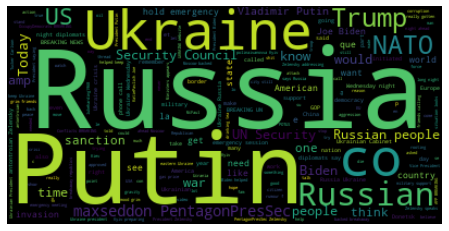

In [22]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

stopwords = set(stopwords.words('english')) # get a set of English stop words
stopwords.update(['br', 'href', 'http', 'https', 'RT', 'U', 'de'])
wc = WordCloud(stopwords=stopwords).generate(corpus)

plt.figure(figsize=(12, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### I was going to find some score data for the tweets because I wanted to do sentiment analysis and I need training data to train the model (score data was supposed to classify the sentiment inclination of the text). However, it seems there's no such score or similar data collected.

#### Retweet_count prediction  
Retweet count is an important factor because it represents whether the original tweet is accepted by others.  
This analysis can also help us understand which kinds of tweets (content/title/...) will be acknowledged by others.

In [23]:
df.rt_rt_count

0              NaN
1       1350.00000
2          0.00000
3          1.00000
4          0.00000
           ...    
11957    102.00000
11958     65.00000
11959    446.00000
11960      0.00000
11961    198.00000
Name: rt_rt_count, Length: 11962, dtype: float64

In [24]:
df.rt_rt_count = df.rt_rt_count.fillna(0).apply(int)
df.rt_rt_count

0           0
1        1350
2           0
3           1
4           0
         ... 
11957     102
11958      65
11959     446
11960       0
11961     198
Name: rt_rt_count, Length: 11962, dtype: int64

#### I wish I can get more time to work on this dataset. Twitter data is a quite interenting yet tricky dataset. I had a lot in my mind like sentiment analysis or trying to predict retweet_count.

#### I'm looking forward to join DataFest this year. I applied last year but didn't get a chance. It's really fun to work on a data science project with a group of mates.